# Predicting NBA Player Impact via Multiple Linear Regression

NOTE: At the time of this, all data and analysis were collected at March 1st, 2019. Things would have changed since then.

It's hard to predict how much of an impact a player is making in the NBA. Various statistics have been created to measure such. Player Efficiency Rating (PER) relies on box score stats (rebounds, assists, steals, blocks, points). Real Plus Minus (RPM) measures how well a player does offensively and defensively with any given on court (cuts, screens, boxing out), and how well the team does with that same player on and off court.

But both stats are flawed; both fail to take minutes into account. PER focuses more on numbers than whether a player is a true difference maker on the team. At March 1st 2019, MVP prospect Paul George is ranked lower than backup center Jonas Valanciunas, simply becasue the latter blocks and rebounds more. RPM focuses more on winning percentage. At March 1st 2019, All Star Blake Griffin is ranked under backup center Kevon Looney. Looney plays fewer minutes than Griffin, and his RPM is inflated due to playing on a perfect ball movement system with 2 MVP candidates. Griffin is the number one option on a team with a poor supporting cast. 

John Hollinger realized these flaws and came up with a better statistic: Value Added and Estimated Wins Added (latter is VA expressed in terms of wins, so +1 correlation). In simple terms, he wanted to account minutes into PER. VA much better than PER and is used in award voting, but it still doesn't explain how an All Star like Blake Griffin is ranked lower than a starting center like Jusuf Nurkic. It also ignores the benefits of RPM, which shows player impact on team. 

The goal is to combine different statistics (RPM, PER, Wins, Usage rate/USG, Minutes per game/MPG) and create a linear regression model that can better predict VA. We'll explain later why we chose those particular statistics.

## Web Scraping

In [2]:
from bs4 import BeautifulSoup
import requests
import pandas as pd

rpm_next_url = 'http://www.espn.com/nba/statistics/rpm'
per_next_url = 'http://insider.espn.com/nba/hollinger/statistics'

# Set up empty data list
rpm_data = []
per_data = []

# Set max page limit per url. 
max_rpm_page = 13
max_stat_page = 8

# Initialize counter for loop.
i = 1

# Load in RPM data
while i <= max_rpm_page:   
    #Set as Beautiful Soup Object
    rpm_soup = BeautifulSoup(requests.get(rpm_next_url).content)

    # Go to the section of interest
    rpm_summary = rpm_soup.find("div",{'class':'span-4', 'id':'my-players-table'})

    # Find the tables in the HTML
    rpm_tables = rpm_summary.find_all('table')
    
    # Set rows as first indexed object in tables with a row
    rows = rpm_tables[0].findAll('tr')

    # now grab every HTML cell in every row
    for tr in rows:
        cols = tr.findAll('td')
        # Check to see if text is in the row
        rpm_data.append([])
        for td in cols:
            text = td.find(text=True) 
            rpm_data[-1].append(text)
    
    i = i+1    
            
    try:
        rpm_next_url = 'http://www.espn.com/nba/statistics/rpm/_/page/' + str(i)
        
    except IndexError:
        break
        
# Load in PER and other Stats Data
i = 1

while i <= max_stat_page:   
    #Set as Beautiful Soup Object
    per_soup = BeautifulSoup(requests.get(per_next_url).content)

    # Go to the section of interest
    per_summary = per_soup.find("div",{'class':'col-main', 'id':'my-players-table'})

    # Find the tables in the HTML
    per_tables = per_summary.find_all('table')
    
    # Set rows as first indexed object in tables with a row
    rows = per_tables[0].findAll('tr')

    # now grab every HTML cell in every row
    for tr in rows:
        cols = tr.findAll('td')
        # Check to see if text is in the row
        per_data.append([])
        for td in cols:
            text = td.find(text=True) 
            per_data[-1].append(text)
    
    i = i+1    
            
    try:
        per_next_url = 'http://insider.espn.com/nba/hollinger/statistics/_/page/' + str(i)
    except IndexError:
        break

/Users/hdeva/anaconda3/lib/python3.7/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file /Users/hdeva/anaconda3/lib/python3.7/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup([your markup])

to this:

 BeautifulSoup([your markup], "lxml")

  markup_type=markup_type))


## Data Cleaning

Remove rank from each stat dictionary. We're joining these statistics and will create our own rank

In [3]:
%%capture
def removeRank(stat_list):
    return list(map(lambda stat_record: stat_record.pop(0), stat_list))

removeRank(rpm_data)
per_data.pop(0)
removeRank(per_data)

Rename First column to player - for readability

In [4]:
rpm_df = pd.DataFrame(rpm_data[1:], columns=rpm_data[0])
per_df = pd.DataFrame(per_data[1:], columns=per_data[0])
rpm_df.rename(columns={'NAME': 'PLAYER'}, inplace=True)

Join the two stat dictionaries

In [5]:
metrics_df = pd.merge(rpm_df, per_df, how='left', on=['PLAYER', 'GP', 'MPG'])
metrics_df = metrics_df[metrics_df.PLAYER != 'NAME']

In [6]:
metrics_df.head(25)

,PLAYER,TEAM,GP,MPG,ORPM,DRPM,RPM,WINS,TS%,AST,TO,USG,ORR,DRR,REBR,PER,VA,EWA
0,Paul George,OKC,59,36.7,4.84,3.20,8.04,15.65,.593,13.7,8.4,29.7,3.9,19.2,11.4,24.56,453.7,15.1
1,James Harden,HOU,58,37.4,7.05,0.03,7.08,13.25,.618,18.0,12.5,40.8,2.8,17.5,9.9,30.50,631.8,21.1
2,Nikola Jokic,DEN,60,31.5,4.66,1.83,6.49,11.03,.587,27.0,11.5,30.2,9.8,27.3,18.5,26.74,455.8,15.2
3,Anthony Davis,NO,49,34.7,3.19,3.09,6.28,10.37,.597,14.1,6.8,29.5,9.7,27.4,18.7,30.53,483.0,16.1
4,Giannis Antetokounmpo,MIL,57,33.1,2.90,2.76,5.66,10.52,.637,19.3,12.3,31.7,7.6,30.4,19.6,30.07,522.1,17.4
5,Nikola Vucevic,ORL,62,31.1,1.95,3.47,5.42,10.30,.576,16.7,8.2,27.7,9.2,32.7,20.8,25.92,440.5,14.7
6,Kevin Durant,GS,61,35.5,4.55,0.80,5.35,11.80,.628,18.8,9.8,30.0,1.6,18.6,10.5,24.97,467.8,15.6
7,LeBron James,LAL,44,35.4,3.37,1.87,5.24,8.54,.594,23.1,10.2,31.6,3.2,21.6,12.6,25.80,355.6,11.9
8,Rudy Gobert,UTAH,61,31.8,0.60,4.61,5.21,10.45,.678,14.4,10.6,17.3,13.0,30.6,21.9,24.45,401.1,13.4
9,Stephen Curry,GS,51,34.4,5.70,-0.62,5.08,9.22,.650,17.7,9.4,30.5,2.2,13.9,8.2,25.27,373.5,12.4


In [7]:
metrics_df = metrics_df.fillna(0)

Change data types for correlation comparisons

In [8]:
metrics_df['GP'] = pd.to_numeric(metrics_df['GP'], downcast='integer')
metrics_df['MPG'] = pd.to_numeric(metrics_df['MPG'], downcast='float')
metrics_df['ORPM'] = pd.to_numeric(metrics_df['ORPM'], downcast='float')
metrics_df['DRPM'] = pd.to_numeric(metrics_df['DRPM'], downcast='float')
metrics_df['RPM'] = pd.to_numeric(metrics_df['RPM'], downcast='float')
metrics_df['WINS'] = pd.to_numeric(metrics_df['WINS'], downcast='float')
metrics_df['TS%'] = pd.to_numeric(metrics_df['TS%'], downcast='float')
metrics_df['AST'] = pd.to_numeric(metrics_df['AST'], downcast='float')
metrics_df['TO'] = pd.to_numeric(metrics_df['TO'], downcast='float')
metrics_df['USG'] = pd.to_numeric(metrics_df['USG'], downcast='float')
metrics_df['ORR'] = pd.to_numeric(metrics_df['ORR'], downcast='float')
metrics_df['DRR'] = pd.to_numeric(metrics_df['DRR'], downcast='float')
metrics_df['REBR'] = pd.to_numeric(metrics_df['REBR'], downcast='float')
metrics_df['PER'] = pd.to_numeric(metrics_df['PER'], downcast='float')
metrics_df['VA'] = pd.to_numeric(metrics_df['VA'], downcast='float')
metrics_df['EWA'] = pd.to_numeric(metrics_df['EWA'], downcast='float')

metrics_df.dtypes

PLAYER     object
TEAM       object
GP           int8
MPG       float32
ORPM      float32
DRPM      float32
RPM       float32
WINS      float32
TS%       float32
AST       float32
TO        float32
USG       float32
ORR       float32
DRR       float32
REBR      float32
PER       float32
VA        float32
EWA       float32
dtype: object

## Heatmap

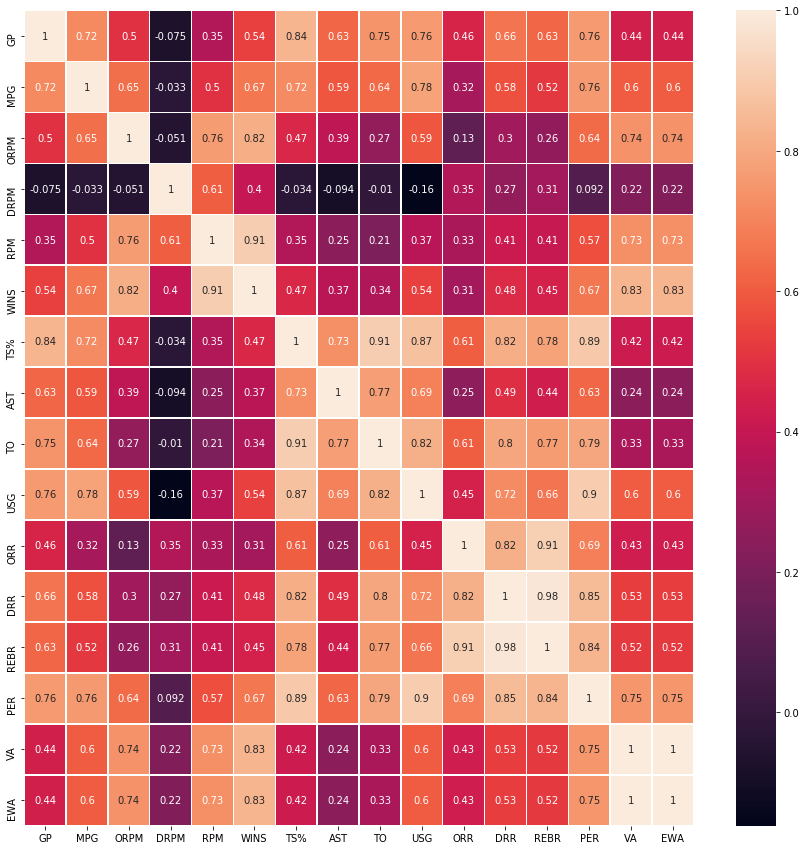

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15,15)) 
sns.heatmap(metrics_df.corr(),annot=True, linewidths=.5, ax=ax)

We can draw all kinds of conclusions with this data. Here's what we noticed at a quick glance.

1) VA and EWA have a positive 1 correlation, which is expected given they're both similar

2) We want to look for moderate positive or strong positive correlations for VA. Only 5 stats fit this: MPG, RPM, WINS, USG, PER. We ignored ORPM as it is included in RPM. 

There's more insights we can draw from, but these two pieces are relevant to what we want to solve. 

# Multiple Linear Regression Model

In [10]:
#Split for Multiple Linear Regression
X_high_correlation = metrics_df[['MPG','RPM','WINS','USG','PER']]
y = metrics_df[['VA']]

# Splitting the dataset into the Training set and Test set
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_high_correlation, y, test_size = 0.2, random_state = 0)


# Fitting Multiple Linear Regression to the Training set
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)

print('Intercept: \n', regressor.intercept_)
print('Coefficients: \n', regressor.coef_)

Intercept: 
 [-38.07886]
Coefficients: 
 [[ -1.5502388 -12.191976   34.559376   -2.2251875   8.137267 ]]


/Users/hdeva/anaconda3/lib/python3.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Let's compare this using stat OLS models

In [11]:
#Getting Regression results using stat models
import statsmodels.api as sm
X_high_correlation = sm.add_constant(X_high_correlation)
model = sm.OLS(y, X_high_correlation).fit()
predictions = model.predict(X_high_correlation)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     VA   R-squared:                       0.779
Model:                            OLS   Adj. R-squared:                  0.777
Method:                 Least Squares   F-statistic:                     343.0
Date:                Sat, 02 Mar 2019   Prob (F-statistic):          5.31e-157
Time:                        18:29:40   Log-Likelihood:                -2620.2
No. Observations:                 493   AIC:                             5252.
Df Residuals:                     487   BIC:                             5278.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -38.2181      7.358     -5.194      0.000     -52.676     -23.760
MPG           -1.7208      0.444     -3.872      0.000      -2.594      -0.848
RPM          -12.7401      2.830     -4.502      0.000     -18.301      -7.179
WINS          35.6467      2.631     13.547      0.000      30.477      40.817
USG           -2.2576      0.666     -3.389      0.001      -3.567      -0.949
PER            8.4047      0.852      9.860      0.000       6.730      10.080
==============================================================================
Omnibus:                       18.603   Durbin-Watson:                   1.919
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               36.425
Skew:                           0.197   Prob(JB):                     1.23e-08
Kurtosis:                       4.272   Cond. No.                         103.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Predict VA for Players

A new column, VA_Pred (Value Added Predicted), will be added to the metrics data frame. We want to see how the rankings change for the top 50 players. 

In [15]:
metrics_df['VA_PRED'] = metrics_df.apply(lambda metrics_df_record: regressor.predict([[metrics_df_record['MPG'],
                                          metrics_df_record['RPM'],
                                          metrics_df_record['WINS'],
                                          metrics_df_record['USG'],
                                          metrics_df_record['PER']]]), axis=1)
metrics_df = metrics_df.sort_values(by=['VA_PRED'], ascending=False)
metrics_df[['PLAYER', 'TEAM','RPM','PER', 'WINS', 'USG', 'VA','VA_PRED']].head(50).reset_index()

,index,PLAYER,TEAM,RPM,PER,WINS,USG,VA,VA_PRED
0,0,Paul George,OKC,8.04,24.559999,15.65,29.700001,453.700012,[[481.62131037399104]]
1,1,James Harden,HOU,7.08,30.500000,13.25,40.799999,631.799988,[[432.9337430812129]]
2,6,Kevin Durant,GS,5.35,24.969999,11.80,30.000000,467.799988,[[385.89316001628913]]
3,4,Giannis Antetokounmpo,MIL,5.66,30.070000,10.52,31.700001,522.099976,[[379.31547699501334]]
4,3,Anthony Davis,NO,6.28,30.530001,10.37,29.500000,483.000000,[[372.7307010929885]]
5,8,Rudy Gobert,UTAH,5.21,24.450001,10.45,17.299999,401.100006,[[370.7092657810217]]
6,2,Nikola Jokic,DEN,6.49,26.740000,11.03,30.200001,455.799988,[[365.54245700965384]]
7,12,Jrue Holiday,NO,4.73,19.639999,11.75,26.799999,297.000000,[[354.69805742116887]]
8,5,Nikola Vucevic,ORL,5.42,25.920000,10.30,27.700001,440.500000,[[352.870045935872]]
9,15,Karl-Anthony Towns,MIN,4.35,26.309999,9.37,27.799999,467.700012,[[333.3157220654907]]


# Conclusions

This new regression model emphasizes more on Wins and RPM. We reset the index to compare how the VA_PRED rankings compared with the original VA rankings. 

Using VA_PRED is advantageous for giving players underrated by the NBA community a better assessment of their value. Kemba Walker, Tobias Harris, Blake Griffin, Montrezl Harrell, De'Aaron Fox, Bradley Beal, LaMarcus Aldridge, Jerami Grant, and Jarrett Allen are better represented by this model. This model accurately places Blake Griffin above Andre Drummond and Kevon Looney (Looney isn't even in the top 50, which is a good sign). It also accurately places Paul George as an MVP candidate, as he is contributing to most of the Thunder's wins. This also places overrated players in correct positions based on the performance they're having this year. LeBron James and Kyle Lowry would normally be ranked correctly by VA, but they are battling injuries this year and haven't had the same impact as prior years due to their supporting cast. Danny Green has been overrated because his breakout performance is due to opponents focusing on his other teammates (Kyle Lowry, Kawhi Leonard, Pascal Siakam, Marc Gasol). Green's VA ranking is similar to Kevon Looney's RPM ranking. 


The biggest surprise is that Pascal Siakam outperformed Blake Griffin, and is better than superstar Kawhi Leonard. Siakam has more of an impact on the Raptors than previously thought, and it is a shame he wasn't voted to the All Stars this year. 

The downside of this model is that it still doesn't accurately predict whether a player's impact is due to himself or his supporting cast. Jusuf Nurkic is still ranked higher than Griffin, Conley, Walker, and Lowry. Nurkic is a talented player, but he benefits from playing with Damian Lillard and CJ McCollum (latter who surprisingly isn't listed in Top 50). Plus, Nurkic's high PER and WINS (as a result of Portland's ball movement system) give him that benefit. Danny Green is still overrated; Horford, Gallinari, Sabonis, Doncic, and Millsap deserve a higher ranking. 